# Auto Encoder - Image Colorization

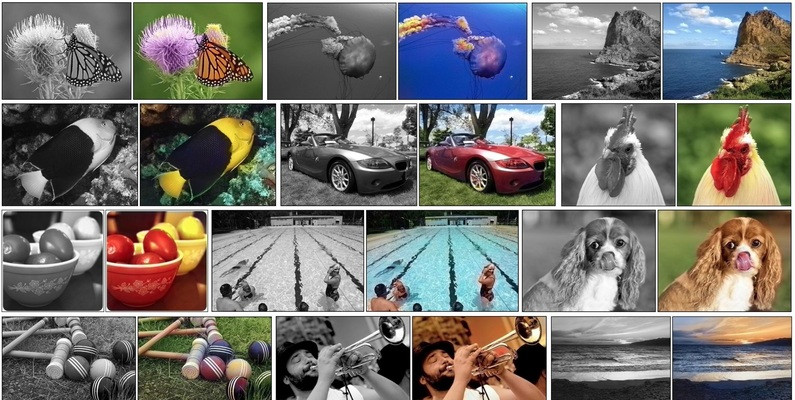

Dataset: [Kaggle](https://www.kaggle.com/datasets/aayush9753/image-colorization-dataset)

Github: https://github.com/aayush9753/ColorIt

In [ ]:
# import library
from google.colab import files # untuk pengaturan files pada google colabs
from glob import glob # untuk mengembalikan larik nama file atau direktori yang cocok dengan pola yang ditentukan

import numpy as np # # untuk membuat objek kelas array tunggal dan multidimensi
import matplotlib.pyplot as plt # untuk visualisasi
from PIL import Image # untuk edit dan visualisasi image

from sklearn.model_selection import train_test_split # untuk splitting daata

import tensorflow as tf # framework machine learning
from tensorflow.keras import layers, models, optimizers, backend
from keras.utils.vis_utils import plot_model # untuk output model berupa image

import warnings
warnings.filterwarnings('ignore')

## Data Loading

In [ ]:
uploaded = files.upload() # upload file

Saving kaggle.json to kaggle.json


In [ ]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

kaggle.json


In [ ]:
!kaggle datasets download -d theblackmamba31/landscape-image-colorization # download file dari kaggle

 96% 185M/192M [00:04<00:00, 51.6MB/s]
100% 192M/192M [00:04<00:00, 46.2MB/s]


In [ ]:
!unzip -qq landscape-image-colorization.zip

In [ ]:
%cd 'landscape Images'
%ls

/content/landscape Images
color/  gray/


## Data Preparation


Data pada autoencoder dibagi menjadi dua yaitu
*   Feature adalah variabel independen yang bertindak sebagai input. Untuk image colorization, kita menggunakan image grayscale sebagai input.
*   Target adalah output dari variabel input. Untuk image colorization, kita menggunakan image color sebagai output.



In [ ]:
%cd ..

/content


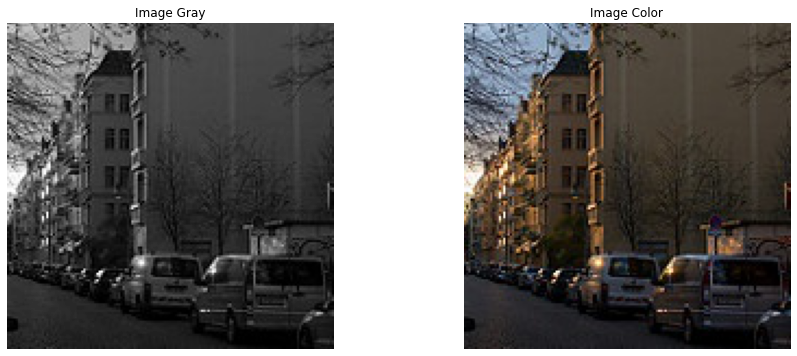

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,6))

gray = plt.imread("landscape Images/gray/0.jpg")
ax1.set_title("Image Gray")
ax1.imshow(gray, cmap='gray')
ax1.axis("off")

#plt.subplot(1, 3, 2)
color = plt.imread("landscape Images/color/0.jpg")
ax2.set_title("Image Color")
ax2.imshow(color)
ax2.axis("off")

plt.show()

In [ ]:
gray_paths = glob('landscape Images/gray/*jpg') # feature x
color_paths = glob('landscape Images/color/*jpg') # target y

In [ ]:
print("Image Gray\t: {}".format(len(gray_paths)))
print("Image Color\t: {}".format(len(color_paths)))

Image Gray	: 7129
Image Color	: 7129


In [ ]:
x_train, x_val, y_train, y_val = train_test_split(gray_paths, color_paths, test_size=0.2, random_state=42)# split 20% untuk validation
print("X train\t: {}".format(len(x_train)))
print("X valid\t: {}".format(len(x_val)))
print("y train\t: {}".format(len(y_train)))
print("y valid\t: {}".format(len(y_val)))

X train	: 5703
X valid	: 1426
y train	: 5703
y valid	: 1426


Sebelum melakukan tahap modelling, kita harus mempersiapkan dataset. Berikut pipeline dataset.
1. Buka file gambar, sebagai matrix 3D
2. Resize jadi ukuran tertentu (height, width)
3. Normalisasi piksel dari 0-255 jadi 0-1
4. Tentukan batch size

In [ ]:
TARGET_SIZE = (128, 128)
BATCH_SIZE = 16
SHUFFLE_BUFFER = 128
PREFETCH = tf.data.AUTOTUNE


@tf.function
def parse_function(x_path, y_path):

  x_file = tf.io.read_file(x_path)
  y_file = tf.io.read_file(y_path)

  x_image = tf.image.decode_jpeg(x_file, channels=3) # matrix 3D
  x_image = tf.image.convert_image_dtype(x_image, dtype=tf.float32) # normalisasi image
  x_image = tf.image.resize(x_image, TARGET_SIZE) # resize image

  y_image = tf.image.decode_jpeg(y_file, channels=3)
  y_image = tf.image.convert_image_dtype(y_image, dtype=tf.float32)
  y_image = tf.image.resize(y_image, TARGET_SIZE)
  
  return x_image, y_image

In [ ]:
# untuk membuat pipeline input train dan validasi dataset tensorflow yg efisien
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)) 
train_dataset = train_dataset.map(parse_function).shuffle(SHUFFLE_BUFFER).batch(BATCH_SIZE).prefetch(PREFETCH)

validation_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
validation_dataset = validation_dataset.map(parse_function).batch(BATCH_SIZE).prefetch(PREFETCH)

In [ ]:
gray.shape, color.shape

((150, 150), (150, 150, 3))

In [ ]:
train_dataset.element_spec, validation_dataset.element_spec

((TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None)),
 (TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None)))

## Modelling

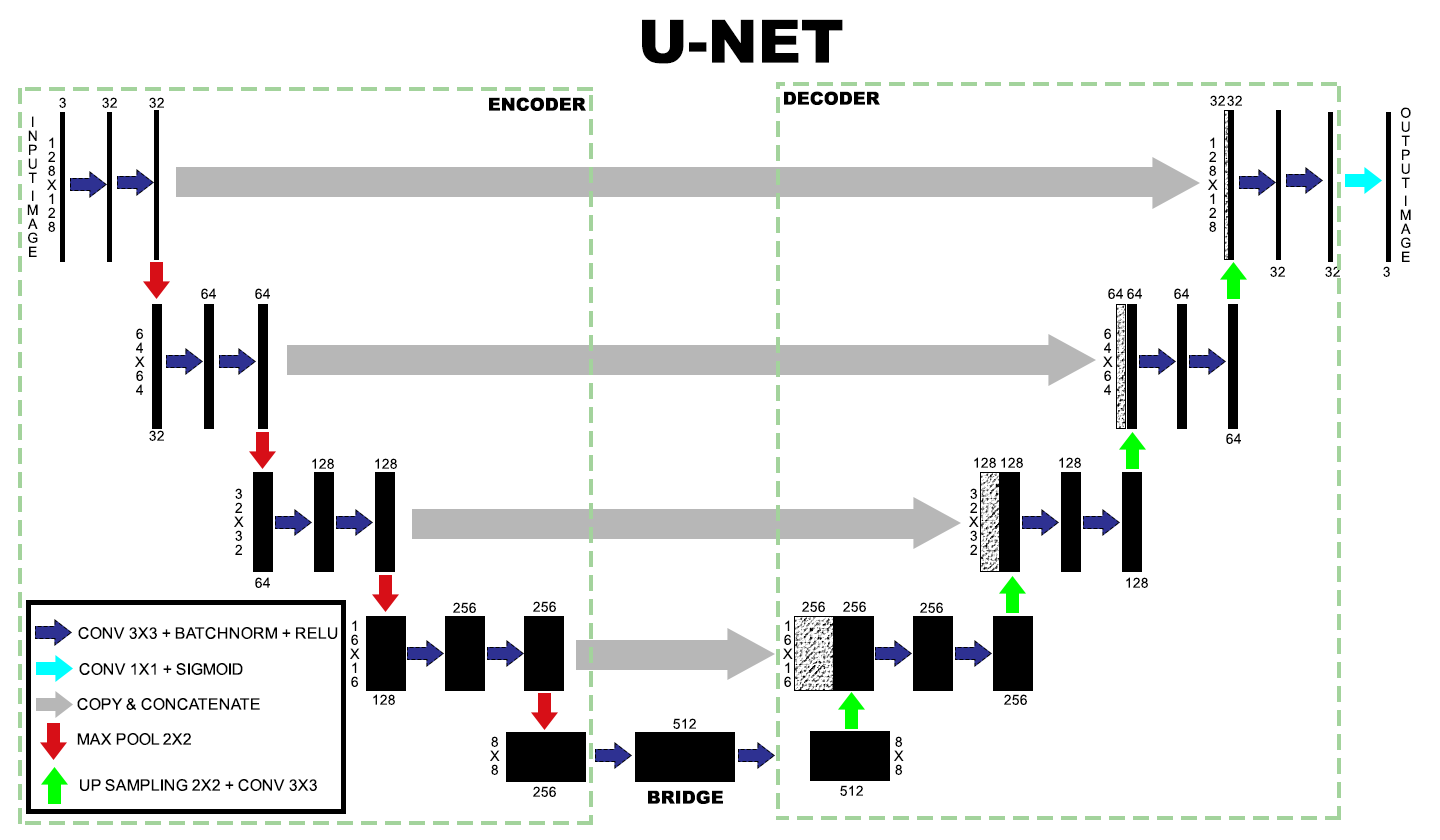

In [ ]:
def conv_block(input, num_filters):
  x = layers.Conv2D(num_filters, 3, padding='same')(input)
  x = layers.BatchNormalization()(x)
  x = layers.Activation('relu')(x)

  return x

def encoder_block(input, num_filters):
  x = conv_block(input, num_filters)
  x = conv_block(x, num_filters)

  p = layers.MaxPool2D(2, 2)(x)

  return x, p

def decoder_block(input, skip_features, num_filters):
  upconv = layers.Conv2DTranspose(num_filters, 3, strides=(2, 2), padding="same")(input)
  upconv = layers.BatchNormalization()(upconv)
  upconv = layers.Activation('relu')(upconv)

  c = layers.Concatenate()([skip_features, upconv])

  y = conv_block(c, num_filters)
  y = conv_block(y, num_filters)

  return y

In [ ]:
backend.clear_session()

inputs = layers.Input(shape=(*TARGET_SIZE, 3)) # (height, width, channels)

s1, p1 = encoder_block(inputs, 32) # skip connection, pooling layer
s2, p2 = encoder_block(p1, 64)
s3, p3 = encoder_block(p2, 128)
s4, p4 = encoder_block(p3, 256)

b = conv_block(p4, 512)

d1 = decoder_block(b, s4, 256)
d2 = decoder_block(d1, s3, 128)
d3 = decoder_block(d2, s2, 64)
d4 = decoder_block(d3, s1, 32)

outputs = layers.Conv2D(3, 1, activation='sigmoid', padding='same')(d4)

model = models.Model(inputs, outputs, name="U-Net")

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 128, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                             

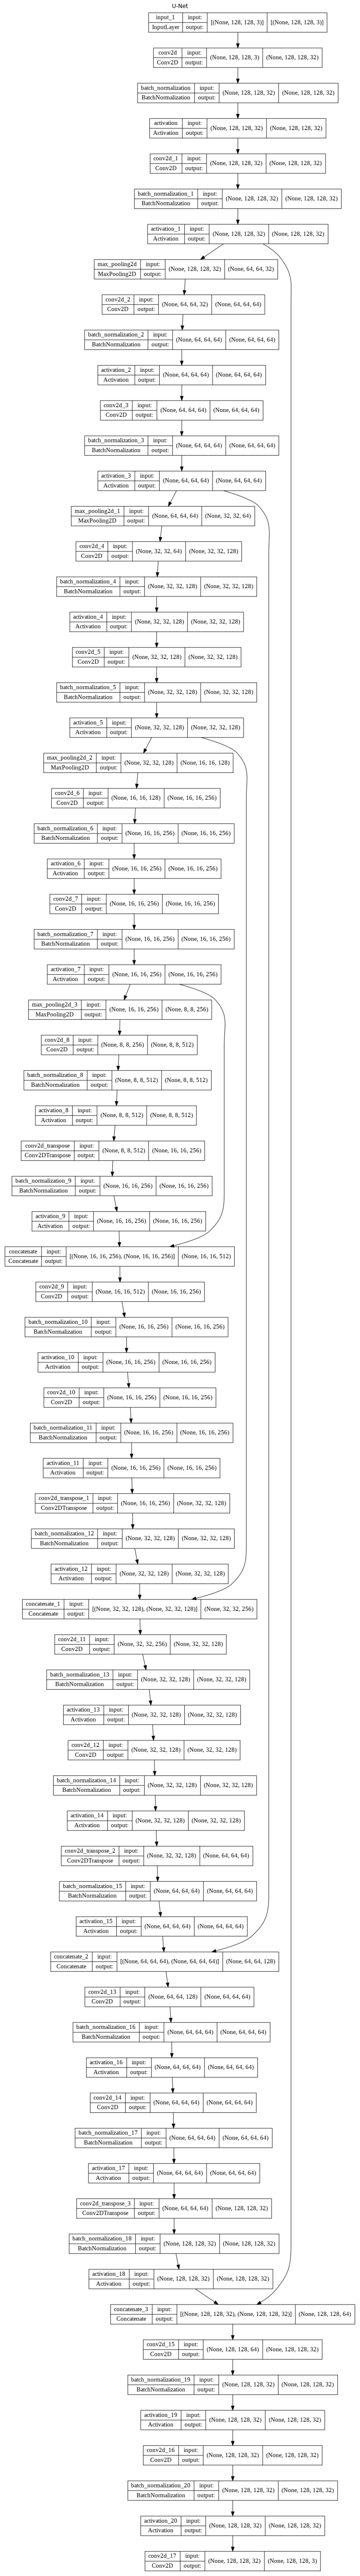

In [ ]:
model_plot = plt.imread('model_plot.png')
plt.figure(figsize=(200,100))
plt.title("U-Net")
plt.imshow(model_plot)
plt.axis('off')
plt.show()

In [ ]:
!wget https://github.com/kurnivan-ny/image/raw/main/model%20U-Net.png

--2022-10-08 12:21:38--  https://github.com/kurnivan-ny/image/raw/main/model%20U-Net.png
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/kurnivan-ny/image/main/model%20U-Net.png [following]
--2022-10-08 12:21:38--  https://raw.githubusercontent.com/kurnivan-ny/image/main/model%20U-Net.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 898135 (877K) [image/png]
Saving to: ‘model U-Net.png’

model U-Net.png     100%[===================>] 877.08K  --.-KB/s    in 0.004s  

2022-10-08 12:21:39 (192 MB/s) - ‘model U-Net.png’ saved [898135/898135]



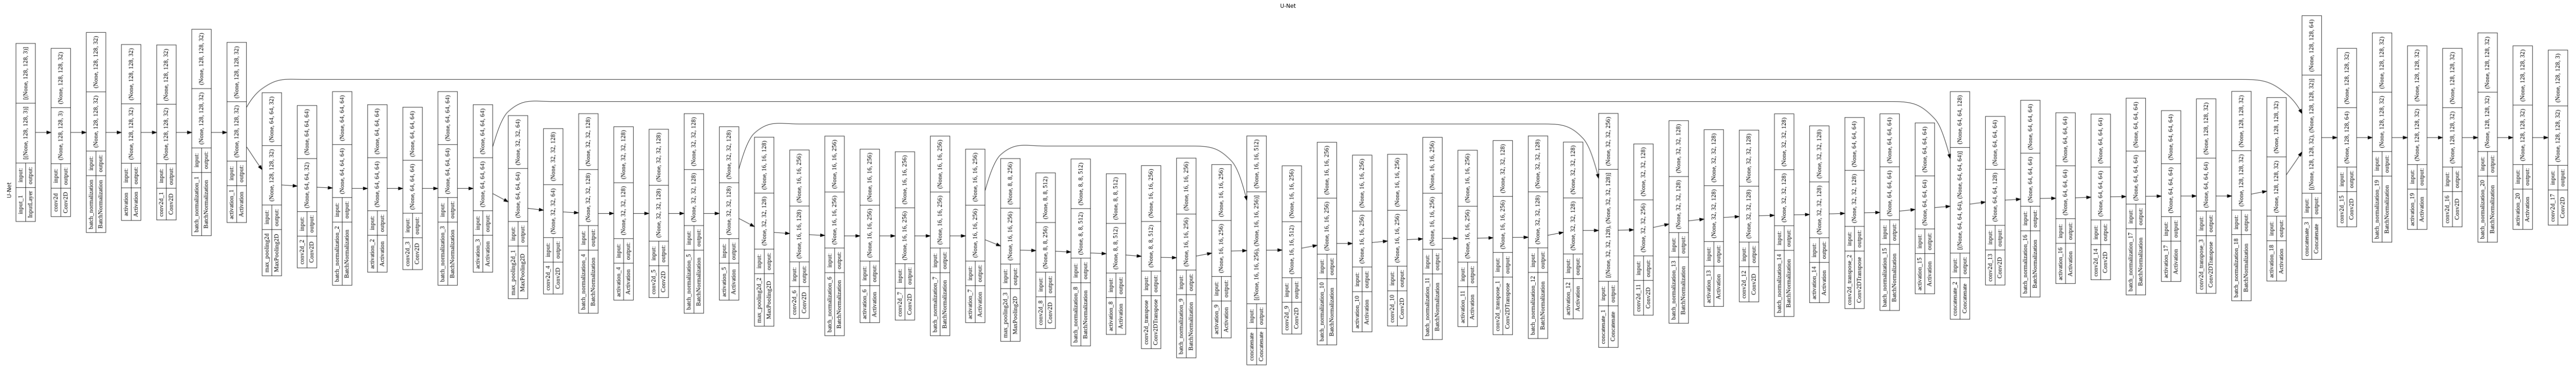

In [ ]:
model_plot = plt.imread('model U-Net.png')
plt.figure(figsize=(100,200))
plt.title("U-Net")
plt.imshow(model_plot)
plt.axis('off')
plt.show()

In [ ]:
# metriks evaluasi model menggunakan pnsr dan ssim
def psnr(pred, gt):
  return tf.image.psnr(pred, gt, max_val=1.0)

def ssim(pred, gt):
  return tf.image.ssim(pred, gt, max_val=1.0)

model.compile(loss='mse', optimizer=optimizers.Nadam(learning_rate=1e-3), metrics=[psnr, ssim])

In [ ]:
history = model.fit(
              x=train_dataset,
              validation_data=validation_dataset,
              epochs=20
          )

Epoch 1/20
357/357 [==============================] - 65s 131ms/step - loss: 0.0087 - psnr: 22.0972 - ssim: 0.8619 - val_loss: 0.0278 - val_psnr: 15.9001 - val_ssim: 0.6498
Epoch 2/20
357/357 [==============================] - 44s 122ms/step - loss: 0.0067 - psnr: 23.1540 - ssim: 0.9171 - val_loss: 0.0061 - val_psnr: 23.5275 - val_ssim: 0.9169
Epoch 3/20
357/357 [==============================] - 44s 122ms/step - loss: 0.0064 - psnr: 23.3802 - ssim: 0.9243 - val_loss: 0.0062 - val_psnr: 23.4072 - val_ssim: 0.9217
Epoch 4/20
357/357 [==============================] - 44s 122ms/step - loss: 0.0061 - psnr: 23.6865 - ssim: 0.9306 - val_loss: 0.0059 - val_psnr: 23.7097 - val_ssim: 0.9260
Epoch 5/20
357/357 [==============================] - 44s 122ms/step - loss: 0.0060 - psnr: 23.7428 - ssim: 0.9321 - val_loss: 0.0126 - val_psnr: 19.7122 - val_ssim: 0.8728
Epoch 6/20
357/357 [==============================] - 44s 122ms/step - loss: 0.0058 - psnr: 23.8706 - ssim: 0.9337 - val_loss: 0.0060 -

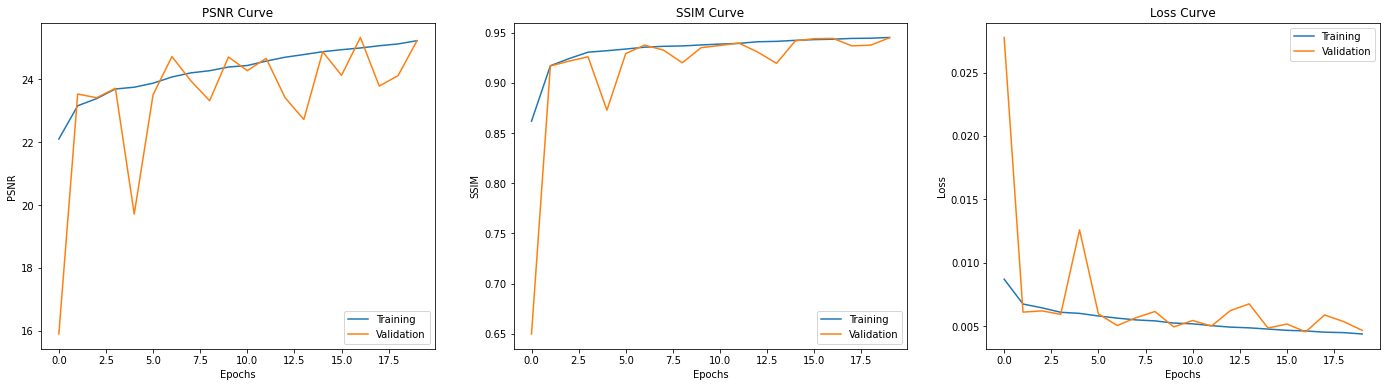

In [ ]:
train_psnr = history.history['psnr']
val_psnr = history.history['val_psnr']

train_ssim = history.history['ssim']
val_ssim = history.history['val_ssim']

train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(24,6))
plt.subplot(1, 3, 1)
plt.title('PSNR Curve')
plt.plot(train_psnr, label='Training')
plt.plot(val_psnr, label='Validation')
plt.legend(loc='lower right')
plt.xlabel('Epochs')
plt.ylabel('PSNR')

plt.subplot(1, 3, 2)
plt.title('SSIM Curve')
plt.plot(train_ssim, label='Training')
plt.plot(val_ssim, label='Validation')
plt.legend(loc='lower right')
plt.xlabel('Epochs')
plt.ylabel('SSIM')

plt.subplot(1, 3, 3)
plt.title('Loss Curve')
plt.plot(train_loss, label='Training')
plt.plot(val_loss, label='Validation')
plt.legend(loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.show()

In [ ]:
for black, color in zip(x_val[:40], y_val[:40]):
  x, y = parse_function(black, color)
  pred = model(np.expand_dims(x, axis=0))
  y_hat = np.squeeze(pred, axis=0)

  plt.figure(figsize=(15, 5))
  plt.subplot(1, 3, 1)
  plt.title('Gray')
  plt.imshow(x)
  plt.axis('off')
  plt.subplot(1, 3, 2)
  plt.title('Prediction')
  plt.imshow(y_hat)
  plt.axis('off')
  plt.subplot(1, 3, 3)
  plt.title('Ground Truth')
  plt.imshow(y)
  plt.axis('off')
  plt.show()

In [ ]:
model.save("model_autoencoder.h5")

In [ ]:
model_autoencoder = tf.keras.models.load_model("model_autoencoder.h5", custom_objects={"psnr": psnr, "ssim": ssim})

In [ ]:
model_autoencoder.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 128, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                             

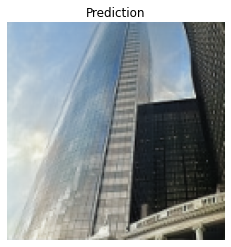

In [ ]:
TARGET_SIZE = (128, 128)

test_path = '/content/landscape Images/color/0.jpg'

test_file = tf.io.read_file(test_path)

test_image = tf.image.decode_jpeg(test_file, channels=3) # matrix 3D
test_image = tf.image.convert_image_dtype(test_image, dtype=tf.float32) # normalisasi image
test_image = tf.image.resize(test_image, TARGET_SIZE) # resize image

pred = model_autoencoder(np.expand_dims(x, axis=0))
y = np.squeeze(pred, axis=0)
plt.title('Prediction')
plt.imshow(y)
plt.axis('off')
plt.show()